# Rollin' your own neural network

Back in my day we didn't have any fancy tensor flows or pytorches. We had to compute our gradients uphill, through the snow, both ways.

## The plan

This notebook contains a derivation of all the gradients for a two-layer perceptron with sigmoid activation functions. At each step, I've added some skeleton code for you to actually implement the math, as well as a test you can use to verify your implementation.

Feel free to add whatever extra cells you need to experiment with your code.

At the end, take your new homemade AI out for a spin!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import pandas as pd

%matplotlib inline
from IPython.core.pylabtools import figsize

In [63]:
def close_enough(a, b, epsilon=1e-5):
    """
    Macro for building tests
    """
    if np.max(np.abs((a-b)/(b+epsilon**2))) < epsilon:
        print("LOOKS GOOD")
    else:
        assert False, "NOT CLOSE ENOUGH"

## Backpropagation

We have a cross-entropy loss function- for a single training example,

$L = -y\log\hat{y} - (1-y)\log(1-\hat{y})$

Where $y$ is the label and $\hat{y}$ is the network's output:

$\hat{y} = \sigma(s)$

* Our activation function is the sigmoid $\sigma(x) = \left(1+ e^{-x} \right)^{-1}$ 
* The input to the activation function is a linear model $s = \sum_{j}h_{j}w_{j}$
* The inputs to the linear model are weights $w_{j}$ and outputs of the hidden neurons $h_{j}$

For each hidden neuron,

$h_{j} = \sigma(s^{h}_{j})$

* The input to the activation function is $s^{h}_{j} = \sum_{k}x_{k}w^{h}_{kj}$
* The $w^{h}_{kj}$ are hidden-layer weights and $x_{k}$ are the data inputs to the model.

#### Efficiently computing for a batch

Let's say we start with a (N,K) data matrix $X$ containing $N$ length-$K$ feature vectors. To include a bias term, we'll concatenate a 1 to the end of every vector, so $X'$ will be (N,K+1). For a hidden-layer (H,K+1) weight matrix $W_{h}$:

$h = \sigma(W_{h}X^{'T})$

where $h$ is (H,N).

To add a bias term to the output layer, we can concatenate a 1 on the end of each hidden-layer output, so $h'$ will be (H+1,N). For a (H+1,1) output-layer weight matrix $w$,

$\hat{y} = \sigma(w^{T}h)^{T}$

So the output will be (N,1).

In [64]:
def compute_cross_entropy(y, y_h):
    """
    :y: array of ground-truth labels
    :y_h: array of network outputs
    """
    return -np.sum(y*np.log2(y_h) + (1-y)*np.log2(1-y_h)) # <--

In [65]:
# compute_cross_entropy_test. assumes you used log base 2.
close_enough(compute_cross_entropy(np.array([0,1]), np.array([0.75, 0.25])), 4)

LOOKS GOOD


In [66]:
def sigmoid(x):
    """
    Write a function that inputs an array, and returns
    the element-wise sigmoid of the array. Remember that
    most numpy functions (like np.exp) are automagically
    vectorized.
    """
    return 1./(1+np.exp(-x)) # <---

In [67]:
# sigmoid test!
for (a,b) in [(-1, 0.26894142), (0, 0.5), (1, 0.73105858)]:
    close_enough(sigmoid(a), b)

LOOKS GOOD
LOOKS GOOD
LOOKS GOOD


In [68]:
def compute_h(x, Wh):
    """
    Compute the output of the hidden-layer activations.
        
    :x: a length-K+1  or (N,K+1) array of inputs
    :Wh: (H,K+1) array of hidden-layer weights
    """
    xT = x.T  # <--
    WhxT = Wh.dot(xT) # <--
    return sigmoid(WhxT) # <--

In [69]:
# compute_h test!
a = compute_h(np.ones((2,3)), np.arange(9).reshape((3,3)))
b = np.array([[ 0.95257,  0.95257], [ 1,  1], [ 1.,  1.]])
close_enough(a,b)

LOOKS GOOD


In [70]:
def compute_y_hat(h, w):
        """
        Compute the output of the final layer, given
        the hidden layer
        
        :h: (H+1,N) output of hidden layer activations (+1)
        :w: (H+1,1) array of output-layer weights
        """
        wTh = w.T.dot(h)  # <--
        return sigmoid(wTh).T # <--

In [71]:
# compute_y_hat test!
a = compute_y_hat(np.ones((3,2)), np.arange(3).reshape((3,1)))
b = np.array([[ 0.95257413], [ 0.95257413]])
close_enough(a,b)

LOOKS GOOD


In order to do gradient descent, we need to know the partial derivative $\partial L/\partial w$ with respect to every weight in the model.

### Output layer

This layer is easier so we'll do it first. We could expand the partial derivative $\partial L/\partial w_{j}$,

$\frac{\partial L}{\partial w_{j}} = \left(\frac{\partial L}{\partial \hat{y}} \right)  \left(\frac{\partial \hat{y}}{\partial s} \right) \left(\frac{\partial s}{\partial w_{j}} \right)$

The first term in the product is computable from the first equation above:

$\frac{\partial L}{\partial \hat{y}} = \frac{-y}{\hat{y}} + \frac{1-y}{1-\hat{y}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}$

The second term is just the derivative of the sigmoid function:

$\frac{\partial \hat{y}}{\partial s} = \frac{\partial}{\partial s}\sigma(s) = \sigma(s)(1-\sigma(s)) = \hat{y}(1-\hat{y})$

The third is the derivative of a linear function:

$\frac{\partial s}{\partial w_{j}} = \frac{\partial }{\partial w_{j}}\sum_{j'}h_{j'}w_{j'} = h_{j}$

Putting it all together:

$\frac{\partial L}{\partial w_{j}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}\hat{y}(1-\hat{y})h_{j} = (\hat{y}-y)h_{j}$

So the gradient of the loss function with respect to the $j$th weight in the output layer (the weight that tells us how much to weigh the $j$th neuron in the hidden layer) is proportional to the residual of the network and the output of the $j$th neuron.

#### Efficiently computing over a batch

We want to average the gradient over a batch:

$\frac{\partial L}{\partial \vec{w}} = \frac{1}{N}\sum_{n=1}^{N}(\hat{y}_{n}-y_{n})h_{n}$

$y$ and $\hat{y}$ are (N,1), and $h'$ is (H+1,N). We can compute this part of the gradient with a single matrix multiplication:

$\frac{\partial L}{\partial \vec{w}} = \frac{1}{N}h'(\hat{y}-y)$

In my code, I didn't bother with the $1/N$ part of the gradient because we'll arbitrarily scale the learning rate anyway.

In [72]:
def compute_output_gradient(Y, y_h, hprime):
    """
    :Y: (N,1) array of labels
    :y_h: (N,1) array of network outputs
    :hprime: (H+1,N) array of hidden-layer outputs
    """
    return hprime.dot(y_h - Y) # <--

In [73]:
# compute_output_gradient test!
a = compute_output_gradient(np.ones((5,1)), 0.5*np.ones((5,1)), np.ones((3,5)))
b = np.array([[-2.5], [-2.5], [-2.5]])
close_enough(a,b)

LOOKS GOOD


### Hidden layer

Same basic idea, but the result will be a bit more complicated.


$\frac{\partial L}{\partial w^{h}_{jk}} = \left(\frac{\partial L}{\partial s }\right) \left(\frac{\partial s}{\partial h_{j}} \right) \left(\frac{\partial h_{j}}{\partial s^{h}_{j}} \right) \left(\frac{\partial s^{h}_{j}}{\partial w^{h}_{jk}} \right)$

The first term we can pull from the output-layer step:

$\frac{\partial L}{\partial s } = \hat{y}-y$

The second term is the derivative of the output-layer linear function with respect to one of its inputs:

$\frac{\partial s}{\partial h_{j}} = w_{j}$

The third term is just the derivative of a sigmoid:

$\frac{\partial h_{j}}{\partial s^{h}_{j}} = h_{j}(1-h_{j})$

The final term is the derivative of the linear model in the $j$th hidden layer by its $k$th weight:

$\frac{\partial s^{h}_{j}}{\partial w^{h}_{jk}} = x_{k}$

Putting it all together:

$\frac{\partial L}{\partial w^{h}_{jk}} = (\hat{y}-y)w_{j}h_{j}(1-h_{j})x_{k}$

#### Efficiently computing over a batch


Just like for the output layer, we want to average the gradient over a batch:

$\frac{\partial L}{\partial w^{h}_{jk}} = \frac{1}{N}\sum_{n=1}^{N}(\hat{y}_{n}-y_{n})w_{j}h_{j,n}(1-h_{j,n})x_{k,n}$

which we could simplify to

$\frac{1}{N} w^{[K+1]}\otimes\left(\left[ h \otimes (1-h)\right] \text{diag}(\hat{y}-y)X'\right)$

where:

* $\otimes$ is the Hadamard (elementwise) product
* $\text{diag}(\vec{a})$ is a square matrix with $\vec{a}$ on the diagonal and 0 elsewhere
* $w^{[K+1]}$ a (H,K+1) array where every column is the first H elements of $w$

checking dimensions,

* $X'$ is (N,K+1)
* $h$ is (H,N)
* $h\otimes (1-h)$ is (H,N)
* $\text{diag}(\hat{y}-y)$ is (N,N)
* so $\left[ h \otimes (1-h)\right] \text{diag}(\hat{y}-y)X$ is (H,N) times (N,N) times (N,K+1) = (H,K+1)
* $w^{[K+1]}\otimes\left(\left[ h \otimes (1-h)\right] \text{diag}(\hat{y}-y)X'\right)$ is (H,K+1). 

so we'll get the same dimensions as our hidden-layer weight matrix $W_{h}$.

In [74]:
def compute_hidden_weight_gradient(X, Y, y_h, h, w):
        """
        The hidden-weight gradient part is a mess so let's give
        that its own function
        
        :X: an (N,K+1) array of feature vectors
        :Y: (N,1) array of labels
        :y_h: (N,1) array of network outputs
        :h: (H,N) array of hidden-layer outputs
        :w: (H+1,1) weight matrix
        """
        # first H elements of w
        wK = w[:-1]  # <--
        # h(1-h)
        h1h = h*(1-h)  # <--
        # diagonal matrix (hint- use (y_h-Y)[:,0] ) 
        diag = np.diag((y_h-Y)[:,0]) # <--
        # put it all together
        return wK*(h1h.dot(diag).dot(X)) # <---

In [77]:
# compute_hidden_weight_gradient test!
a = compute_hidden_weight_gradient(np.ones((2,2)), np.ones((2,1)), 0.5*np.ones((2,1)), 
                               np.arange(6).reshape((3,2)), np.ones((4,1)))
b = np.array([[  0.,   0.], [  4.,   4.], [ 16.,  16.]])
close_enough(a,b)

LOOKS GOOD


In [78]:
class MultiLayerPerceptron(object):
    """
    A two-class categorizer with a single hidden layer and sigmoid
    activation functions.
    """
    
    def __init__(self, K, H):
        """
        :K: dimension of input feature vectors
        :H: number of hidden units
        """
        self.K = K
        self.H = H
        # run weight initializer
        self._setup()
        
    def _setup(self):
        """
        Initialize weights here.
        """
        # add an output-layer weight array to self.w. It should
        # be randomly initialized with a small variance, and have
        # shape (self.H+1, 1) 
        self.w = np.random.normal(0, 0.05, (self.H+1,1))  # <---
        # add a 2D array of hidden-layer weights to self.Wh. It should
        # be randomly initialized with a small variance, and have
        # shape (self.H, self.K+1)
        self.Wh = np.random.normal(0, 0.05, (self.H, self.K+1)) # <---
        
    def _prepare_x(self, x):
        """
        Reshape x and add an extra "1" for the bias. this part
        isn't terribly interesting so I'll just take care of it.
        
        x: a length-K  or (N,K) array of inputs
        """
        x = x.reshape(-1, self.K)
        return np.hstack([x, np.ones((x.shape[0],1))])
    
    def _prepare_y(self, Y):
        return Y.reshape((Y.size,1))
    
    def _hprime(self, h):
        return np.vstack([h, np.ones(h.shape[1])])
    
    def predict(self, X):
        """
        Input feature vector or matrix X, return network
        predictions
        """
        # prepare X with an additional 1
        Xprime = self._prepare_x(X)
        # compute hidden-layer outputs and an additional 1
        h = compute_h(Xprime, self.Wh)
        hprime = self._hprime(h)
        # compute and return output layer
        return compute_y_hat(hprime, self.w)
    
       
    def cross_entropy_loss(self, X, Y):
        """
        Compute cross-entropy for a training set
        """
        return compute_cross_entropy(self._prepare_y(Y), self.predict(X))
    
    def update_weights(self, X, Y, lr=0.01):
        """
        The main training function. Update hidden and output layer
        weights using gradient descent.
        
        :lr: learning rate
        """
        # reshape X and Y
        X = self._prepare_x(X)  # <--
        Y = self._prepare_y(Y) # <---
        # compute h, hprime, and y_hat
        h = compute_h(X, self.Wh) # <--
        hprime = self._hprime(h) # <---
        y_hat = compute_y_hat(hprime, self.w)  # <---
        
        # update output-layer gradient.
        output_gradient = compute_output_gradient(Y, y_hat, hprime) # <--
        self.w -= lr*output_gradient  # < --
        
        # update hidden-layer gradient
        hidden_gradient = compute_hidden_weight_gradient(X, Y, y_hat, h, self.w)  # <--
        self.Wh -= lr*hidden_gradient # <--
        

## Examples


### OR gate

In [79]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([0,1,1,1])

In [80]:
model_or = MultiLayerPerceptron(2, 5)

In [81]:
for i in range(10000):
    model_or.update_weights(X,Y, 0.1)
    if i % 1000 == 0:
        print(model_or.cross_entropy_loss(X,Y))

3.678495357
0.0837115569502
0.029053566778
0.0169655791923
0.0118367608289
0.00903549727145
0.00728133972966
0.00608407049674
0.00521693652732
0.00456105436167


In [82]:
np.round(model_or.predict(X),2)

array([[ 0.],
       [ 1.],
       [ 1.],
       [ 1.]])

### XOR gate

In [83]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([0,1,1,0])

In [86]:
model_xor = MultiLayerPerceptron(2, 5)

In [87]:
for i in range(100000):
    model_xor.update_weights(X,Y, 0.1)
    if i % 10000 == 0:
        print(model_xor.cross_entropy_loss(X,Y))

4.00332656335
3.9999769795
0.0213471555676
0.00648291055301
0.00373836565077
0.00260921844411
0.00199795932075
0.00161606399137
0.00135533792667
0.00116624297004


In [88]:
np.round(model_xor.predict(X),2)

array([[ 0.],
       [ 1.],
       [ 1.],
       [ 0.]])

### Categorization in 2D

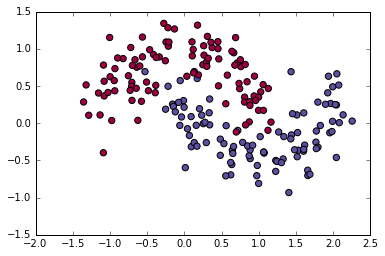

In [89]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral);

In [90]:
model = MultiLayerPerceptron(2, 10)

In [91]:
xx, yy = np.meshgrid(np.linspace(-3,3,25), np.linspace(-3,3,25))
grid_inputs = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
grid_inputs.shape

(625, 2)

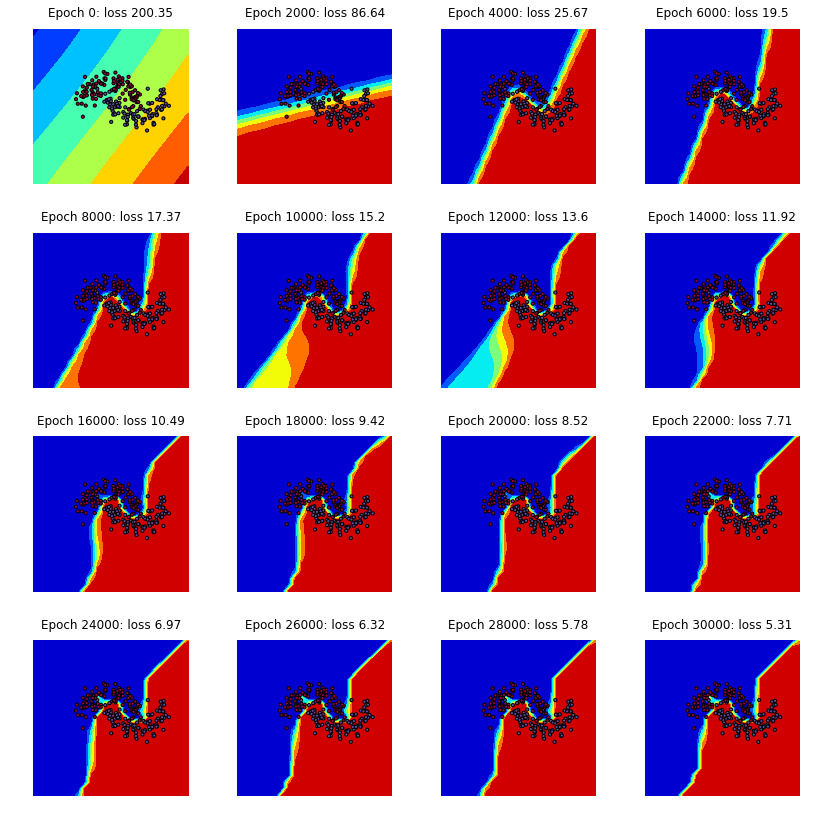

In [92]:
figsize(14,14)
s = 1
for i in range(32000):
    model.update_weights(X,y)
    if i % 2000 == 0:
        plt.subplot(4,4,s)
        net_out = model.predict(grid_inputs).reshape(xx.shape)
        plt.contourf(xx, yy, net_out)
        plt.scatter(X[:,0], X[:,1], s=10, c=y, cmap=plt.cm.Spectral);
        plt.title("Epoch %s: loss %s"%(i, round(model.cross_entropy_loss(X,y),2)))
        plt.axis("off")
        s += 1